In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/significant-features-data.csv')
data.head()

,Admission grade,Age at enrollment,Curricular units 1st sem (enrolled),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,Target,y_labels
0,0.340000,0.056604,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.372093,0.488889,Dropout,-1
1,0.500000,0.037736,0.230769,0.230769,0.741722,0.26087,0.30,0.735897,0.732558,0.111111,Graduate,1
2,0.313684,0.037736,0.230769,0.000000,0.000000,0.26087,0.00,0.000000,0.372093,0.488889,Dropout,-1
3,0.258947,0.056604,0.230769,0.230769,0.711447,0.26087,0.25,0.667692,0.209302,0.000000,Graduate,1
4,0.489474,0.528302,0.230769,0.192308,0.653422,0.26087,0.30,0.700000,0.732558,0.111111,Graduate,1


In [3]:
feature_columns = data.columns.drop(['Target', 'y_labels'])
X = data[feature_columns].to_numpy(dtype=float)
y = data['y_labels'].to_numpy(dtype=int)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [5]:
# Polynomial Kernel
def polynomial_kernel(A, B, *, degree=3, gamma=1., coef0=1.):
    """
    K(x, x') = (gamma * <x, x'> + coef0)^degree
    """
    return (gamma * (A @ B.T) + coef0) ** degree

In [6]:
# Gaussian Kernel
def gaussian_kernel(A, B, *, gamma=1.):
    """
    K(x, x') = exp( - gamma * ||x - x'||^2 )
    """
    A2 = (A**2).sum(1)[:, None]
    B2 = (B**2).sum(1)[None, :]
    return np.exp(-gamma * (A2 + B2 - 2 * (A @ B.T)))

In [7]:
def train_kernel_svm_sgd(X, y, kernel, T=1000, C=1.0, **kernel_params):
    """
    Dual-SGD for hinge-loss SVM using a precomputed Gram matrix.
    Returns the averaged alpha coefficients.
    """
    n = X.shape[0]
    # precompute Gram matrix
    K = kernel(X, X, **kernel_params)
    
    # betas accumulate raw counts; we'll convert to alphas each step
    beta = np.zeros(n)
    alpha_sum = np.zeros(n)
    
    for t in range(1, T + 1):
        # compute current alphas from beta
        alpha = beta / (2 * C * t)
        
        # uniformly pick one example at random
        j = np.random.randint(n)
        
        # decision function margin for j
        margin_j = y[j] * np.dot(alpha * y, K[:, j])
        
        # if margin_j < 1, we incur hinge loss → update beta_j
        if margin_j < 1:
            beta[j] += y[j]
        
        alpha_sum += alpha
    
    # return the averaged alpha over all iterations
    return alpha_sum / T

In [8]:
def predict_kernel_svm(alpha, X_train, X_eval, kernel, **kernel_params):
    """
    Predict sign( f(x) ) where
      f(x) = sum_i alpha_i * K(x_i, x)
    """
    return np.sign(alpha @ kernel(X_train, X_eval, **kernel_params))

In [9]:
def cross_validate(params, X, y, kernel, *, k_folds=5, T=1000):
    """
    Perform k-fold cross-validation for kernel SVM with given parameters
    Returns average accuracy across folds
    """
    C = params['C']
    kernel_params = {}
    for key, val in params.items():
        if key != 'C':
            kernel_params[key] = val

    acc = []
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        alpha = train_kernel_svm_sgd(X_tr, y_tr, kernel, C=C, T=T, **kernel_params)
        preds = predict_kernel_svm(alpha, X_tr, X_val, kernel, **kernel_params)

        acc.append((preds == y_val).mean())

    return np.mean(acc)

In [10]:
def grid_search_svm(X, y, kernel, param_grid, *, k_folds=5, T=1000, n_jobs=-1):
    """
    Perform grid search to find best hyperparameters
    Returns best parameters and best score
    """
    grid = list(ParameterGrid(param_grid))

    best_score = -float('inf')   # start lower than any real score
    best_params = None

    for params in grid:
        score = cross_validate(params, X, y, kernel, k_folds=k_folds, T=T)

        if score > best_score:
            best_score  = score
            best_params = params

    return best_params, best_score

In [11]:
# Hyperparameter grid for Polynomial kernel
poly_grid = dict(
    degree=[2, 3, 4],                         
    gamma=[1e-4, 1e-3, 1e-2, 0.1, 1],         
    coef0=[0, 0.5, 1, 2],                     
    C=[
        1e-4, 3e-4, 1e-3, 3e-3,               
        1e-2, 3e-2, 1e-1, 0.3,                
        1, 3, 10                              
    ]
)

In [12]:
# Hyperparameter grid for Gaussian kernel
gaussian_grid = dict(
    gamma=[
        1e-5, 3e-5, 1e-4, 3e-4,            
        1e-3, 3e-3, 1e-2, 3e-2,
        1e-1, 3e-1, 1, 3                   
    ],
    C=[
        1e-4, 3e-4, 1e-3, 3e-3,            
        1e-2, 3e-2, 1e-1, 0.3,             
        1, 3, 10                           
    ]
)

In [13]:
# Perform grid search for polynomial kernel
print(">> Polynomial grid-search")
best_poly, poly_cv = grid_search_svm(X_train, y_train, polynomial_kernel, poly_grid)
print("Best poly params:", best_poly, "CV =", poly_cv)

>> Polynomial grid-search
Best poly params: {'C': 1, 'coef0': 0, 'degree': 3, 'gamma': 1} CV = 0.7973964950974516


In [14]:
# Perform grid search for Gaussian kernel
print("\n>> Gaussian grid-search")
best_gaussian, gaussian_cv = grid_search_svm(X_train, y_train, gaussian_kernel, gaussian_grid)
print("Best gaussian params:", best_gaussian, "CV =", gaussian_cv)


>> Gaussian grid-search
Best gaussian params: {'C': 0.1, 'gamma': 3} CV = 0.8101143528396424


In [15]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title, fontsize=15, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

In [19]:
def plot_roc_pr_curves(y_true_binary, y_scores):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title('ROC Curve', fontsize=15, pad=20)
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true_binary, y_scores)
    pr_auc = auc(recall, precision)
    
    ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Precision-Recall Curve', fontsize=15, pad=20)
    ax2.legend(loc="lower right")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [20]:
def fit_and_eval(best_params, kernel, name, X_train, y_train, X_test, y_test):
    C = best_params['C']
    kernel_params = {}
    for key, val in best_params.items():
        if key != 'C':
            kernel_params[key] = val

    alpha = train_kernel_svm_sgd(X_train, y_train, kernel, C=C, T=1000, **kernel_params)
    
    # Compute decision scores (raw SVM output)
    decision_scores = alpha @ kernel(X_train, X_test, **kernel_params)
    
    # Predicted class labels
    preds = np.sign(decision_scores)
    
    # Probabilities for log-loss (sigmoid)
    probs = 1 / (1 + np.exp(-decision_scores))
    probs = np.vstack([1 - probs, probs]).T

    # True labels must be 0/1 for log-loss
    y_true_binary = (y_test + 1) // 2
    
    # Print metrics
    print(f"\n{name} kernel - Test Metrics:")
    print(f"  Accuracy     : {accuracy_score(y_test, preds):.4f}")
    print(f"  Log-Loss     : {log_loss(y_true_binary, preds):.4f}")
    print(f"  Precision    : {precision_score(y_test, preds):.4f}")
    print(f"  Recall       : {recall_score(y_test, preds):.4f}")
    print(f"  F1 Score     : {f1_score(y_test, preds):.4f}")
    
    # Plot visual metrics
    print(f"\nConfusion Matrix for {name} Kernel:")
    plot_confusion_matrix(y_test, preds, f"Confusion Matrix - {name} Kernel")
    
    print(f"\nROC and PR Curves for {name} Kernel:")
    plot_roc_pr_curves(y_true_binary, decision_scores)

Statisical Analysis Metrics:
- **Accuracy**: Fraction of all students whose outcome (dropout vs. non-dropout) was predicted correctly.
- **Log-Loss**: The negative log-likelihood of the true labels under the model’s predicted probabilities (lower is better).
- **Precision**: Among students predicted to drop out, the fraction who actually did.
- **Recall**: Among students who truly dropped out, the fraction correctly identified.


Polynomial kernel - Test Metrics:
  Accuracy     : 0.8147
  Log-Loss     : 6.6793
  Precision    : 0.8073
  Recall       : 0.9551
  F1 Score     : 0.8750

Confusion Matrix for Polynomial Kernel:


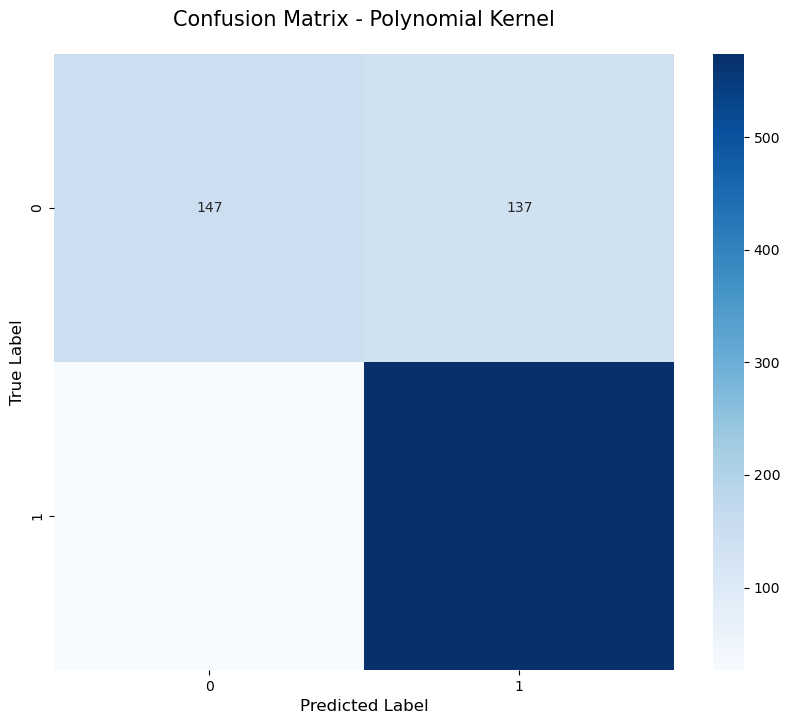


ROC and PR Curves for Polynomial Kernel:


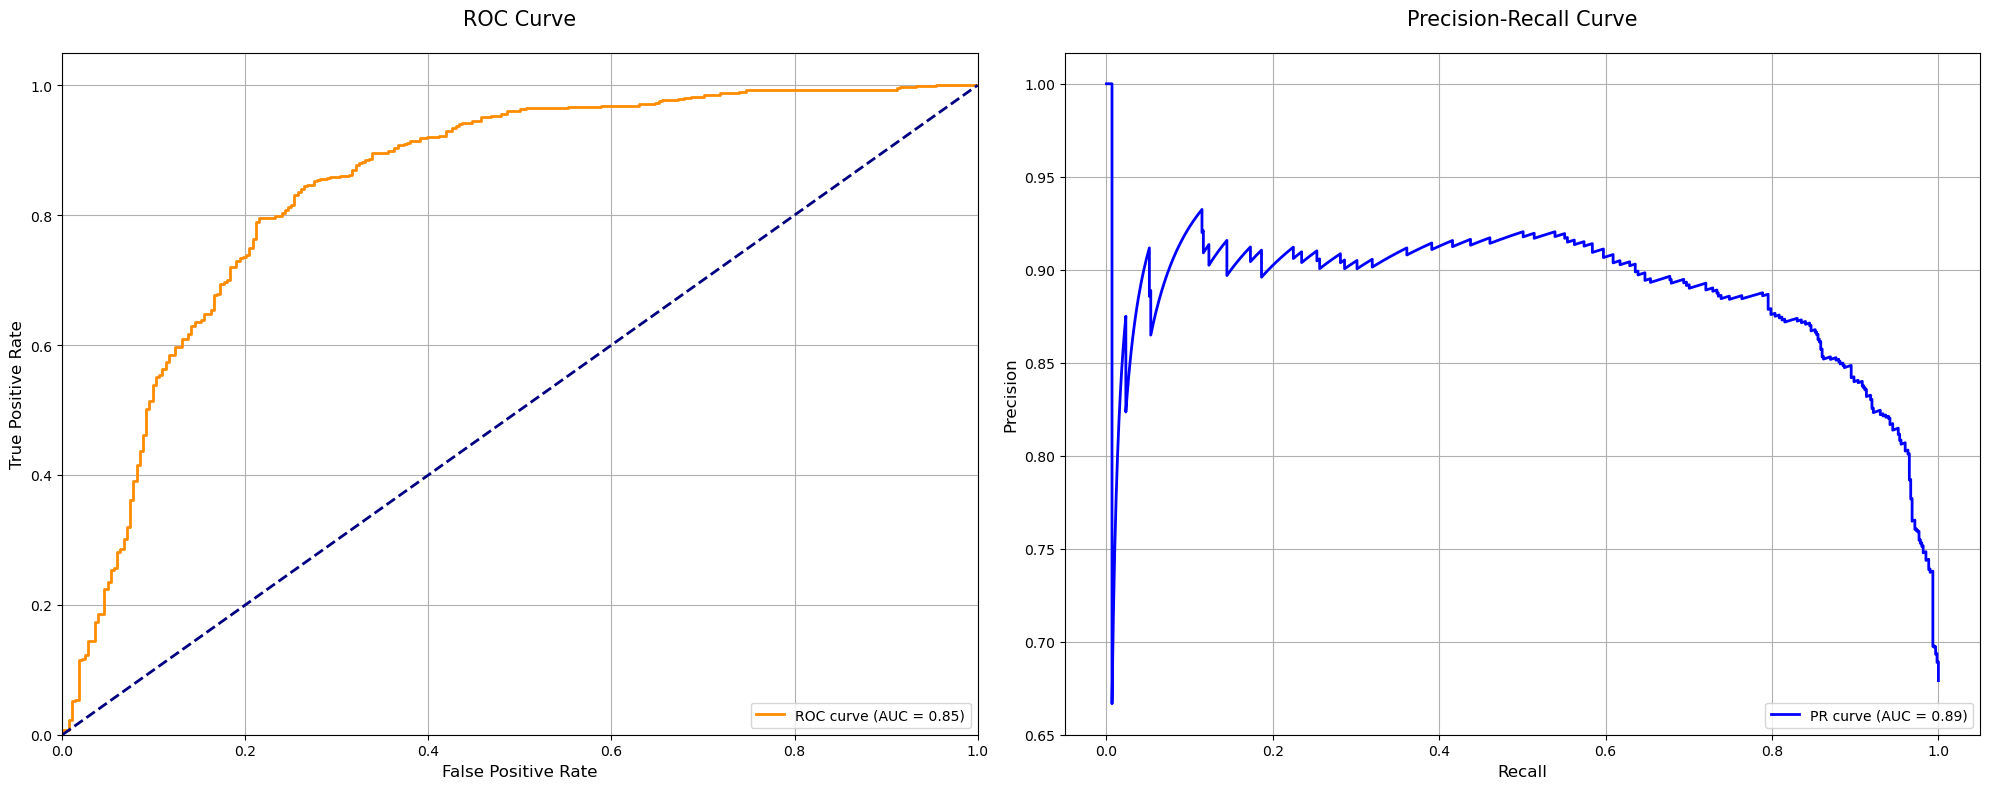

In [29]:
fit_and_eval(best_poly, polynomial_kernel, "Polynomial", X_train, y_train, X_test, y_test)


Gaussian kernel - Test Metrics:
  Accuracy     : 0.8215
  Log-Loss     : 6.4349
  Precision    : 0.8160
  Recall       : 0.9517
  F1 Score     : 0.8786

Confusion Matrix for Gaussian Kernel:


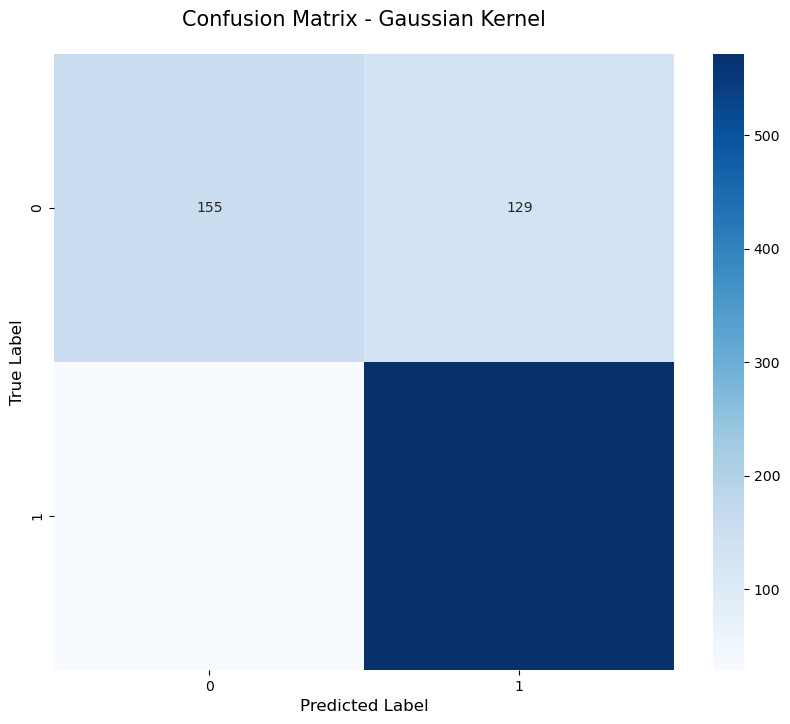


ROC and PR Curves for Gaussian Kernel:


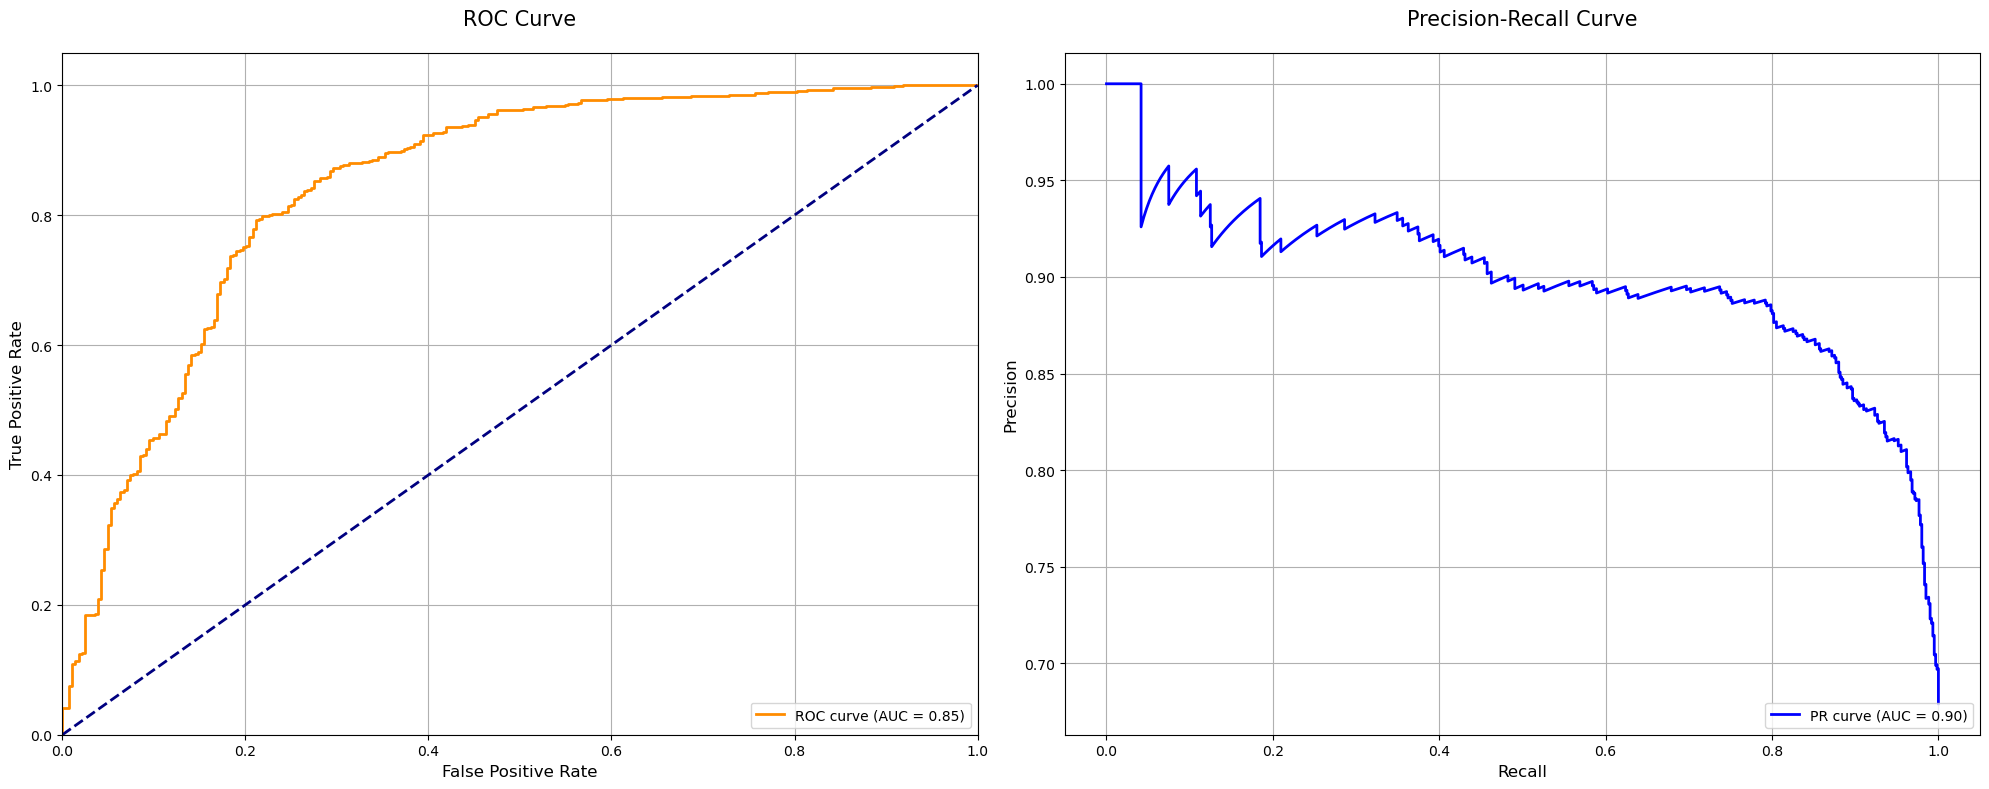

In [25]:
fit_and_eval(best_gaussian, gaussian_kernel, "Gaussian",  X_train, y_train, X_test, y_test)

The following sections detail our evaluation of the model prior to removing the non-significant features from the dataset.

In [30]:
scaled_ordinal_data = pd.read_csv('data/processed-data.csv')

so_columns = scaled_ordinal_data.columns.drop(['Target', 'y_labels'])
X_so = scaled_ordinal_data[so_columns].to_numpy(dtype=float)
y_so = scaled_ordinal_data['y_labels'].to_numpy(dtype=int)

X_so_train, X_so_test, y_so_train, y_so_test = train_test_split(X_so, y_so, test_size=0.2, random_state=0, shuffle=True)

scaled_ordinal_data.head()

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,y_labels
0,0.284211,0.340000,0.056604,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.00,0.000000,0.0,0.372093,0.488889,0.766182,Dropout,-1
1,0.684211,0.500000,0.037736,0.0,0.230769,0.133333,0.230769,0.741722,0.0,0.0,0.26087,0.181818,0.30,0.735897,0.0,0.732558,0.111111,0.640687,Graduate,1
2,0.284211,0.313684,0.037736,0.0,0.230769,0.000000,0.000000,0.000000,0.0,0.0,0.26087,0.000000,0.00,0.000000,0.0,0.372093,0.488889,0.766182,Dropout,-1
3,0.284211,0.258947,0.056604,0.0,0.230769,0.177778,0.230769,0.711447,0.0,0.0,0.26087,0.303030,0.25,0.667692,0.0,0.209302,0.000000,0.124174,Graduate,1
4,0.052632,0.489474,0.528302,0.0,0.230769,0.200000,0.192308,0.653422,0.0,0.0,0.26087,0.181818,0.30,0.700000,0.0,0.732558,0.111111,0.640687,Graduate,1


In [31]:
# Perform polynomial grid search again with scaled ordinal data
print(">> Polynomial grid-search on scaled ordinal data")
best_poly_so, poly_cv_so = grid_search_svm(X_so_train, y_so_train, polynomial_kernel, poly_grid)
print("Best poly params for scaled ordinal processed data:", best_poly_so, "CV =", poly_cv_so)

>> Polynomial grid-search on scaled ordinal data
Best poly params for scaled ordinal processed data: {'C': 0.003, 'coef0': 0, 'degree': 3, 'gamma': 0.1} CV = 0.7742350506237065


In [32]:
# Perfom gaussian grid search with scaled ordinal data
print(">> Gaussian grid-search on scaled ordinal data")
best_gaussian_so, gaussian_cv_so = grid_search_svm(X_so_train, y_so_train, gaussian_kernel, gaussian_grid)
print("Best gaussian params for pre processed data:", best_gaussian_so, "CV =", gaussian_cv_so)

>> Gaussian grid-search on scaled ordinal data
Best gaussian params for pre processed data: {'C': 0.1, 'gamma': 3} CV = 0.7860946627350387



polynomial kernel - Test Metrics:
  Accuracy     : 0.8158
  Log-Loss     : 6.6385
  Precision    : 0.8102
  Recall       : 0.9517
  F1 Score     : 0.8753

Confusion Matrix for polynomial Kernel:


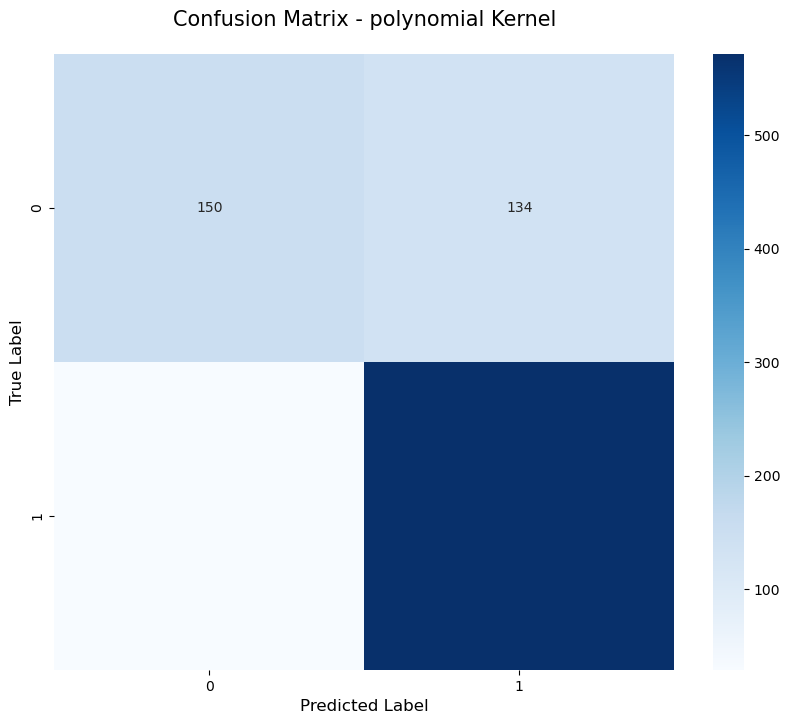


ROC and PR Curves for polynomial Kernel:


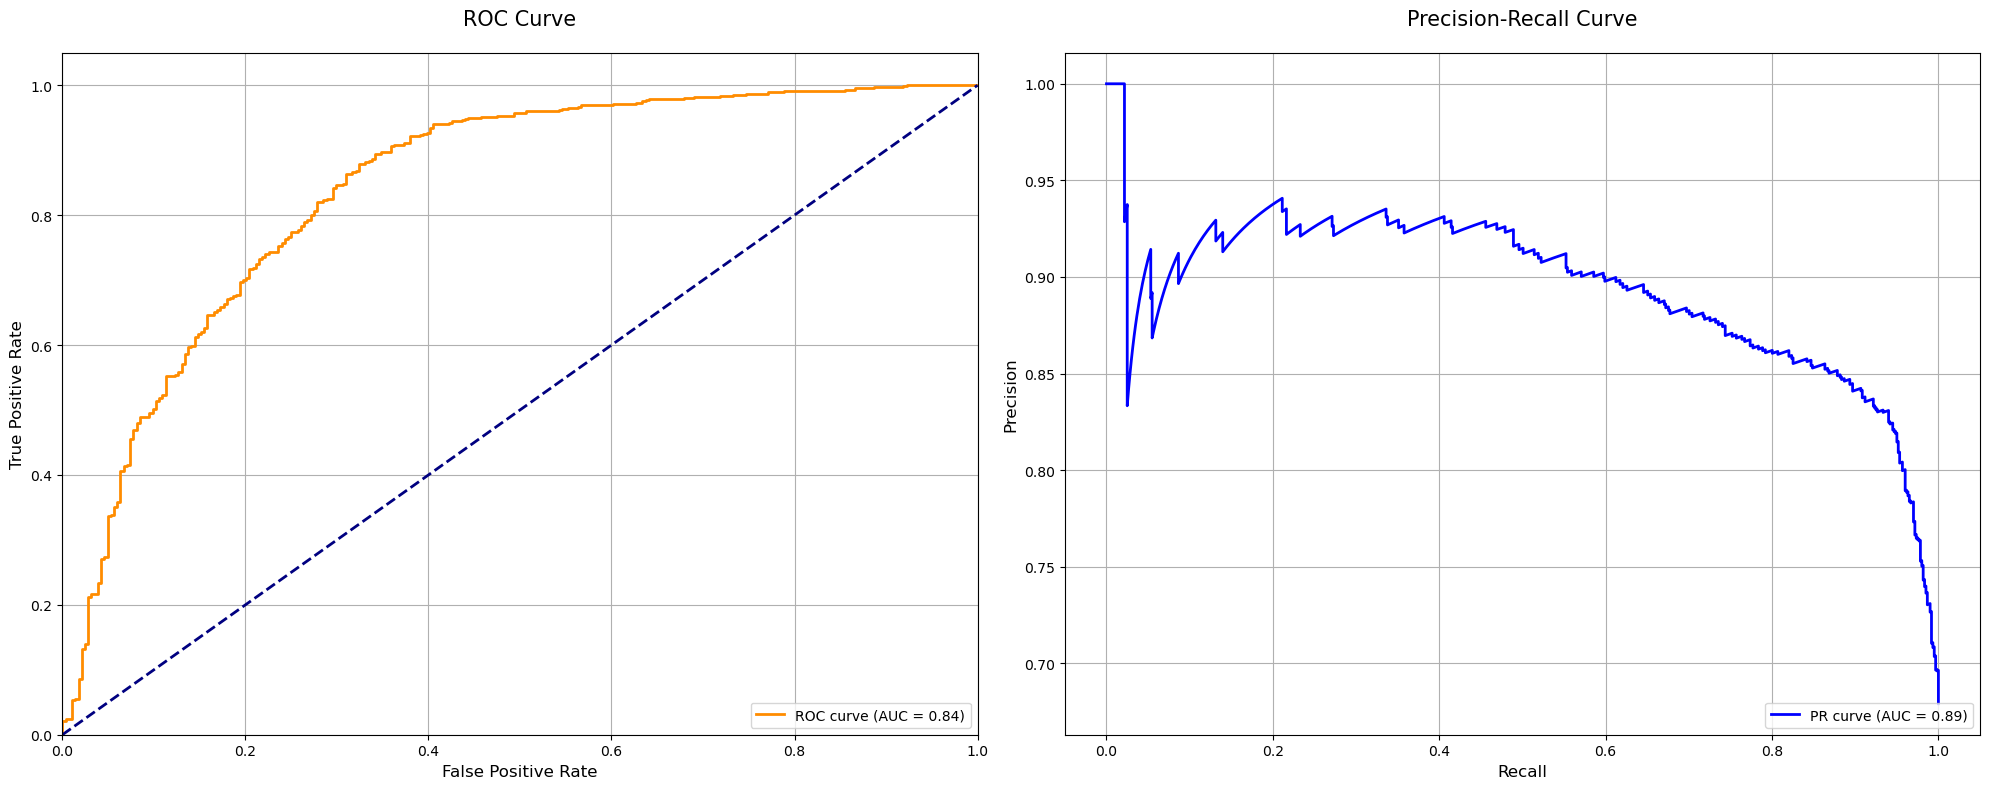

In [36]:
fit_and_eval(best_poly_so, polynomial_kernel, 'polynomial', X_so_train, y_so_train, X_so_test, y_so_test)


gaussian kernel - Test Metrics:
  Accuracy     : 0.8158
  Log-Loss     : 6.6385
  Precision    : 0.8085
  Recall       : 0.9551
  F1 Score     : 0.8757

Confusion Matrix for gaussian Kernel:


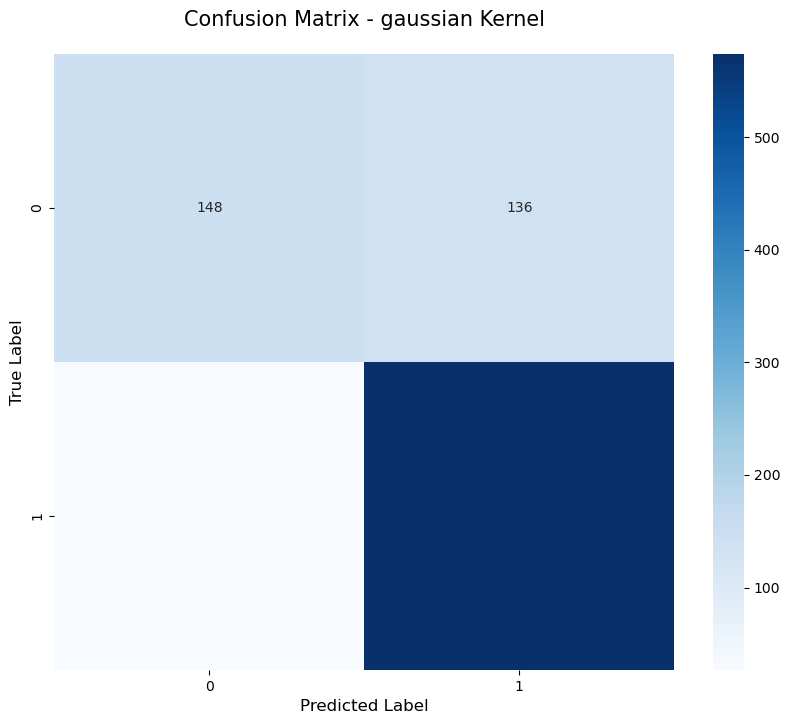


ROC and PR Curves for gaussian Kernel:


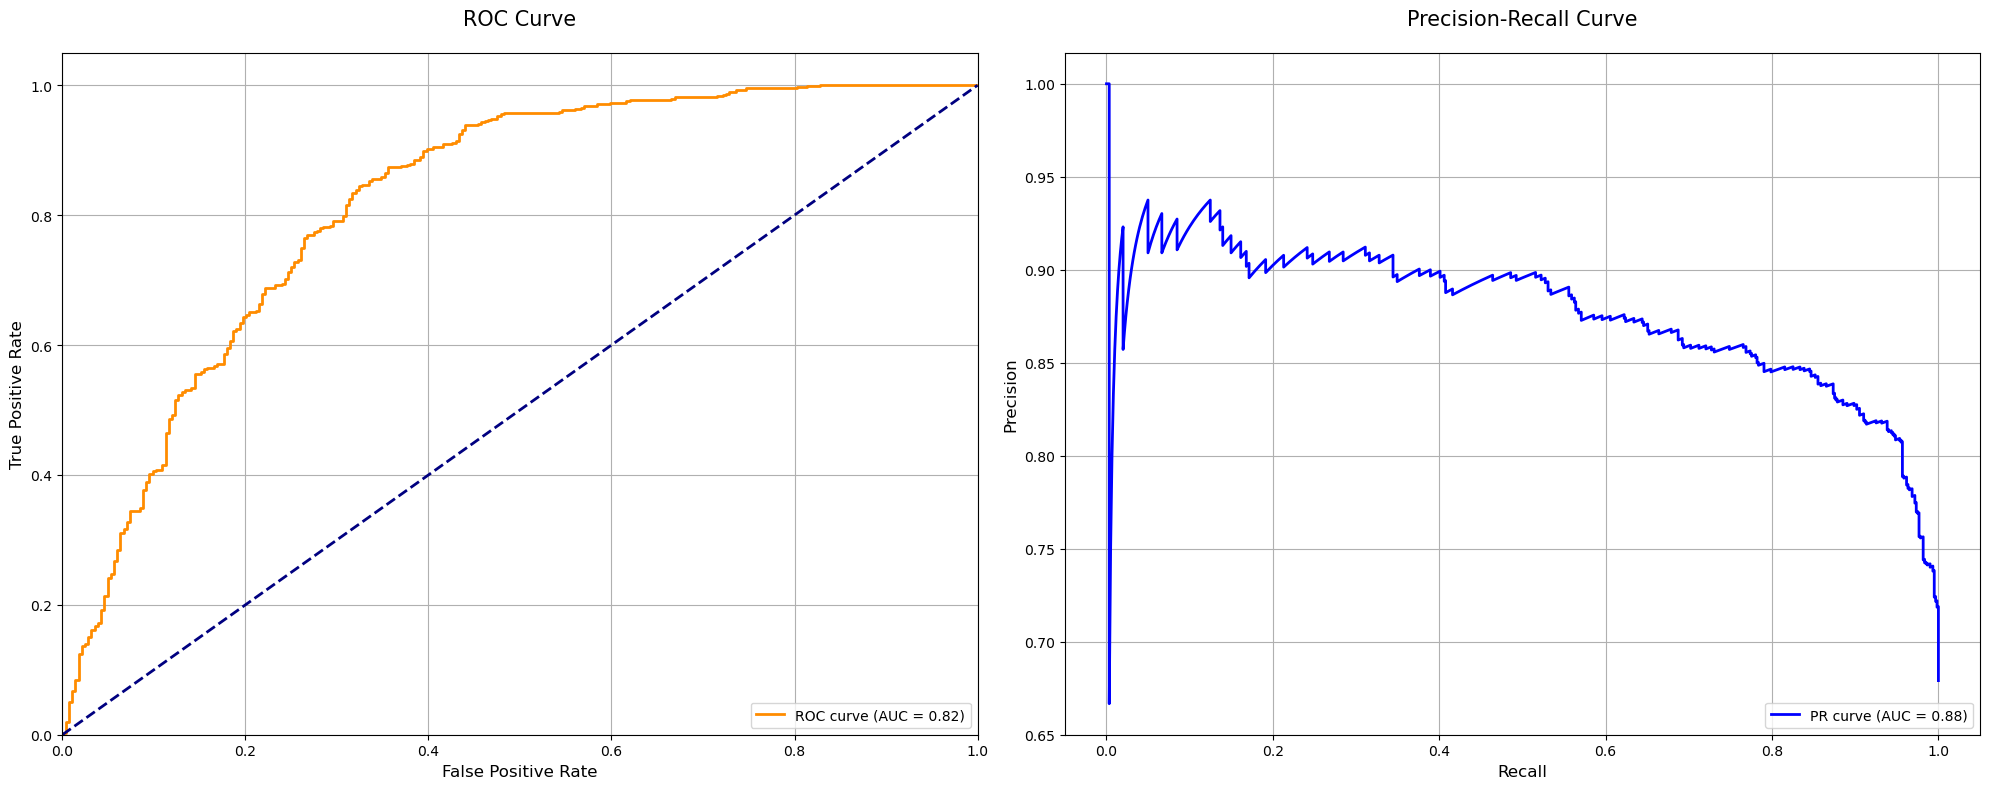

In [43]:
fit_and_eval(best_gaussian_so, gaussian_kernel, 'gaussian', X_so_train, y_so_train, X_so_test, y_so_test)

Because the performance (accuracy) remains the same with or wihout the statistically insignificant features confirms that these features weren't contributing meaningful predictive value.